In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')
from collections import Counter

In [2]:
data_folder = 'data/'
data = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t')

/Users/Crespo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [3]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [4]:
my_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Dairies',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(my_map)

Now the categories are clear:

In [5]:
data['Category'].value_counts()

Unknown              122802
Snacks                37019
Dairies               17932
Composite             14659
Starchy               14600
Fish Meat Eggs        13970
Fruits Vegetables     12623
Beverages             12410
Fat Sauces            11400
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [6]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38490
Beverages                          26082
Sugary snacks                      25179
Dairies                            16129
Meats                               9783
Groceries                           9674
Meals                               8338
Spreads                             4624
Frozen foods                        3152
Fruit juices                        3108
Desserts                            3076
Salty snacks                        3005
Seafood                             2919
Canned foods                        2766
Fats                                1878
Baby foods                          1036
Sweeteners                           944
Sandwiches                           905
Farming products                     796
Fish and meat and eggs               740
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [7]:
my_map_2 = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Dairies',
    'Meats' : 'Fish Meat Eggs',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs'
}

In [8]:
not_in_category = data[data['Category'].isna()]
keys = my_map_2.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5842
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [9]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(my_map_2)
data.loc[new_vals.index, 'Category'] = new_vals

Here is the new 'Category' field.

In [10]:
data['Category'].value_counts()

Unknown              122802
Snacks                37019
Beverages             18252
Dairies               17932
Composite             14675
Starchy               14600
Fish Meat Eggs        14050
Fruits Vegetables     12623
Fat Sauces            11400
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [11]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

The veggie fields from `Category` are also added:

In [12]:
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Fruits Vegetables')
data['Veggie'] = data['Veggie'] | (data['Category'] == 'Starchy')

In [13]:
data['Veggie'].value_counts()

False    657933
True      39891
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [14]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/Users/Crespo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [15]:
beverages = data.query('Category == "Beverages"')

#### Compute points A

In [16]:
# energy
energy_bins = [data['energy_100g'].min() - 1, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

# energy for beverages
#bev_energy_bins = [beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, beverages['energy_100g'].max()]
#bev_energy_points = pd.cut(beverages['energy_100g'], bev_energy_bins, labels=range(11), include_lowest=True)
#data['energy_points'][bev_energy_points.index] = bev_energy_points

# fat
fat_bins = [data['fat_100g'].min() - 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

# sugar
sugar_bins = [data['sugars_100g'].min() - 1, 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

# sugar for beverages
#bev_sugar_bins = [beverages['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, beverages['sugars_100g'].max()]
#bev_sugar_points = pd.cut(beverages['sugars_100g'], bev_sugar_bins, labels=range(11))
#data['sugar_points'][bev_sugar_points.index] = bev_sugar_points

# sodium
sodium_bins = [data['sodium_100g'].min() - 1, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

#### Compute points C

In [17]:
# fruits-vegetables-nuts
fvn_bins = [data['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)

# fruits-vegetables-nuts for beverages
#bev_fvn_bins = [beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, beverages['fruits-vegetables-nuts_100g'].max()]
#bev_fvn_points = pd.cut(beverages['fruits-vegetables-nuts_100g'], bev_fvn_bins, labels=[0,2,4,10])
#data['fvn_points'][bev_fvn_points.index] = bev_fvn_points
data['fvn_points'].fillna(0, inplace=True)

# fiber
fiber_bins = [data['fiber_100g'].min() - 1, 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

# proteins
proteins_bins = [data['proteins_100g'].min() - 1, 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)

data['points_C'] = (data['fvn_points'] + data['fiber_points'] + data['proteins_points'])
data['points_C'].fillna(0, inplace=True)

#### Compute nutri-score

We first compute the nutri-score based on the rules formula mentioned ahead.

In [18]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [19]:
data['nutri-score'] = data.apply(compute_score, axis=1)

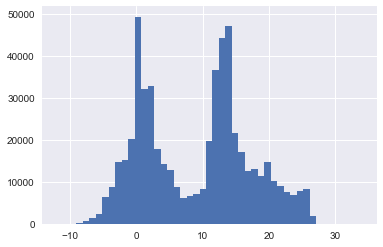

In [20]:
data['nutri-score'].hist(bins=int(data['nutri-score'].max() - data['nutri-score'].min() + 1))

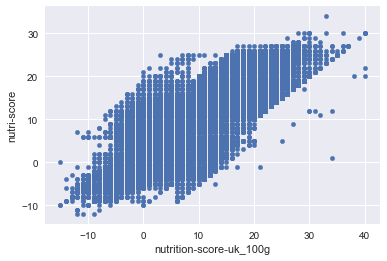

In [21]:
data.plot.scatter('nutrition-score-uk_100g', 'nutri-score')

Now we assign the letter corresponding to the nutri-score.

In [22]:
def nutri_score_letter(row):
    nutri_score = row['nutri-score']
    product_name = row['product_name']
    
    # check if nutri_score is nan
    if nutri_score != nutri_score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if nutri_score <= 1:
            return 'B'
        elif nutri_score <= 5:
            return 'C'
        elif nutri_score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if nutri_score <= -1:
            return 'A'
        elif nutri_score <= 2:
            return 'B'
        elif nutri_score <= 10:
            return 'C'
        elif nutri_score <= 18:
            return 'D'
        else:
            return 'E'

In [23]:
data['nutri-score_letter'] = data.apply(nutri_score_letter, axis=1)

### Analyse the nutri-score across the categories

In [24]:
# Count the letter occurences for each category
letter_counts_per_cat = data.groupby(['Category', 'nutri-score_letter']).count()[['nutri-score']]
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         B                          5316
                  C                          4425
                  D                            84
                  E                          1759
Composite         A                          2250
                  B                          3341
                  C                          4267
                  D                          3701
                  E                            12
Dairies           A                          1051
                  B                          2739
                  C                          4299
                  D                          7542
                  E                           346
Fat Sauces        A                           367
                  B                           969
                  C                          1962
                  D                          3316
                  E                          3282
Fish Meat Eggs    A                          2800
                  B                           871
                  C                           981
                  D                          6896
                  E                            33
Fruits Vegetables A                          3473
                  B                          3272
                  C                          1540
                  D                           793
                  E                           144
Snacks            A                           196
                  B                           642
                  C                          1823
                  D                         14980
                  E                         14876
Starchy           A                          5008
                  B                          2917
                  C                          2204
                  D                          2437
                  E                           168
Unknown           A                         14183
                  B                         22663
                  C                         17232
                  D                         38810
                  E                         12481

In [25]:
# For some categories, some letters are not represented. We add the missing rows with 0 as value.
for cat in letter_counts_per_cat.index.levels[0]:
    for letter in letter_counts_per_cat.index.levels[1]:
        if (cat, letter) not in letter_counts_per_cat.index:
            letter_counts_per_cat.loc[(cat, letter), :] = 0
            
letter_counts_per_cat.sort_index(inplace=True)

In [26]:
# normalize the counts
totals = letter_counts_per_cat.reset_index()[['Category', 'nutri-score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

In [27]:
# colors similar to the original nutri-score ones
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

/Users/Crespo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


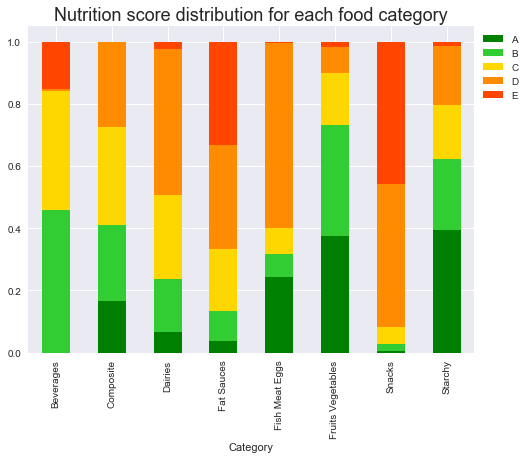

In [28]:
score_distr_per_cat.drop('Unknown').reset_index().pivot(index='Category', columns='nutri-score_letter', values='nutri-score').plot.bar(stacked=True, figsize=(8,6), colors=nutri_score_colors)
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

In [29]:
letter_counts_per_cat

nutri-score
Category          nutri-score_letter             
Beverages         A                           0.0
                  B                        5316.0
                  C                        4425.0
                  D                          84.0
                  E                        1759.0
Composite         A                        2250.0
                  B                        3341.0
                  C                        4267.0
                  D                        3701.0
                  E                          12.0
Dairies           A                        1051.0
                  B                        2739.0
                  C                        4299.0
                  D                        7542.0
                  E                         346.0
Fat Sauces        A                         367.0
                  B                         969.0
                  C                        1962.0
                  D                        3316.0
                  E                        3282.0
Fish Meat Eggs    A                        2800.0
                  B                         871.0
                  C                         981.0
                  D                        6896.0
                  E                          33.0
Fruits Vegetables A                        3473.0
                  B                        3272.0
                  C                        1540.0
                  D                         793.0
                  E                         144.0
Snacks            A                         196.0
                  B                         642.0
                  C                        1823.0
                  D                       14980.0
                  E                       14876.0
Starchy           A                        5008.0
                  B                        2917.0
                  C                        2204.0
                  D                        2437.0
                  E                         168.0
Unknown           A                       14183.0
                  B                       22663.0
                  C                       17232.0
                  D                       38810.0
                  E                       12481.0

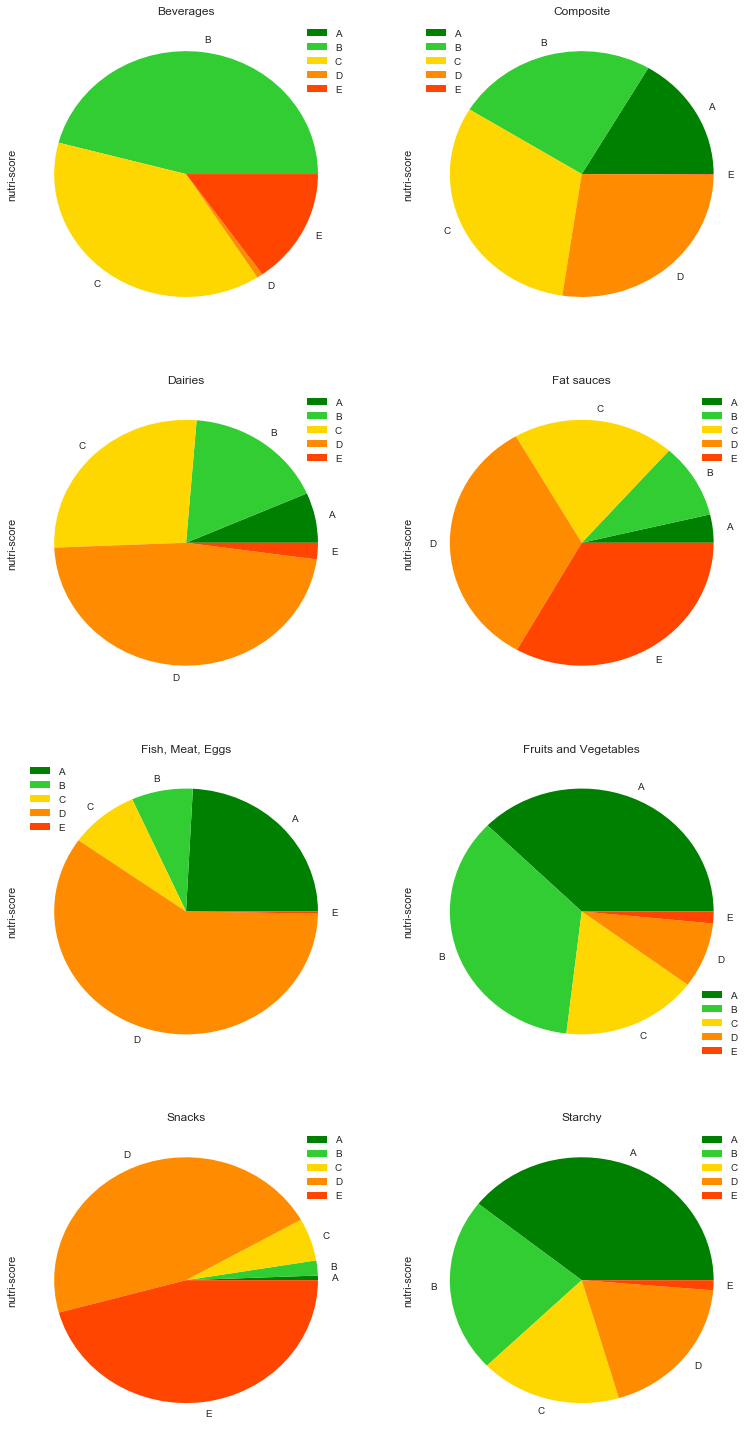

In [30]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('nutri-score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('nutri-score', ax=plt.subplot(422), title='Composite', colors=nutri_score_colors)
letter_counts_per_cat.loc['Dairies'].plot.pie('nutri-score', ax=plt.subplot(423), title='Dairies', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('nutri-score', ax=plt.subplot(424), title='Fat sauces', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs'].plot.pie('nutri-score', ax=plt.subplot(425), title='Fish, Meat, Eggs', colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('nutri-score', ax=plt.subplot(426), title='Fruits and Vegetables', colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('nutri-score', ax=plt.subplot(427), title='Snacks', colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('nutri-score', ax=plt.subplot(428), title='Starchy', colors=nutri_score_colors)

In [31]:
score_mean_by_category = data[['Category', 'nutri-score']].groupby('Category').mean()
score_mean_by_category

,nutri-score
Category,
Beverages,3.279696
Composite,4.929629
Dairies,8.300682
Fat Sauces,12.640865
Fish Meat Eggs,7.545117
Fruits Vegetables,1.669703
Snacks,17.428699
Starchy,2.972515
Unknown,8.481906


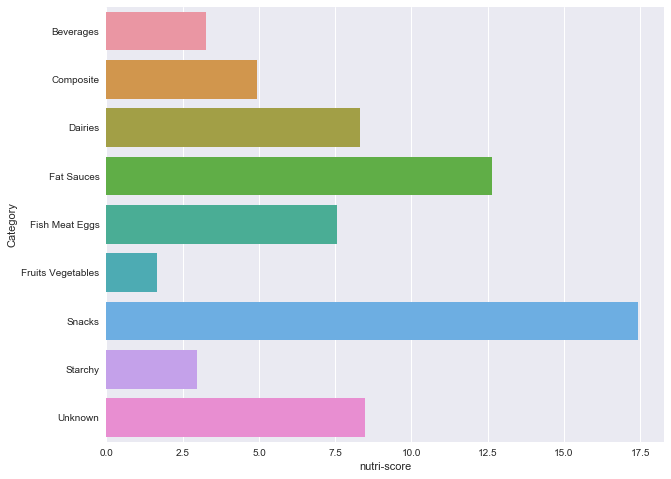

In [32]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category['nutri-score'], score_mean_by_category.index,orient='h')

In [33]:
carbon_mean_by_category = data[['Category', 'carbon-footprint_100g']].groupby('Category').mean()

In [34]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).corr()

,carbon-footprint_100g,nutri-score
carbon-footprint_100g,1.000000,0.209623
nutri-score,0.209623,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a173d1c18>,
      dtype=object)

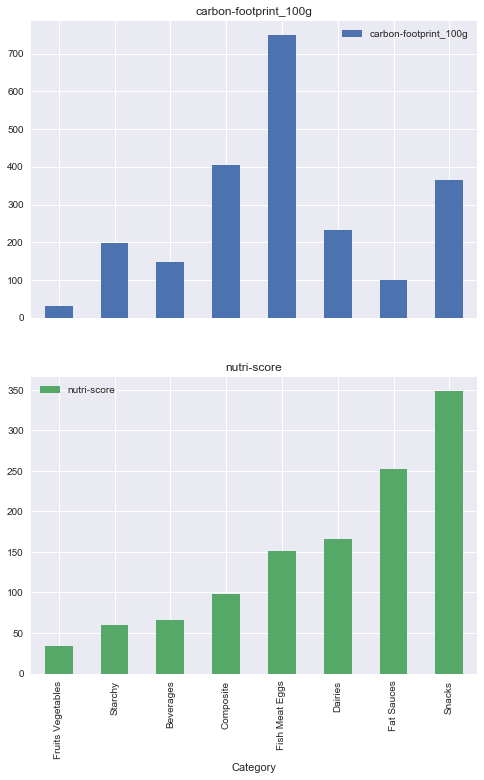

In [35]:
pd.concat((carbon_mean_by_category, 20*score_mean_by_category), axis=1).drop('Unknown').sort_values('nutri-score').plot.bar(subplots=True, figsize=(8, 12))

In [36]:
countries_en_scores = {}

In [37]:
def random_stuff(row):
    letter = row['nutri-score_letter']
    if letter == letter:
        for exportator in row['countries_en'].split(','):
            if exportator in countries_en_scores:
                countries_en_scores[exportator] += [row['nutri-score_letter']]
            else:
                countries_en_scores[exportator] = [row['nutri-score_letter']]

In [38]:
data[data['countries_en'].notna()].apply(random_stuff, axis=1);

In [39]:
threshold = 1

In [40]:
{country: Counter(countries_en_scores[country]) for country in countries_en_scores if len(countries_en_scores[country]) > threshold}

{'France': Counter({'D': 140843,
          'B': 73279,
          'C': 56283,
          'A': 38094,
          'E': 57039}),
 'United States': Counter({'D': 60226,
          'A': 26679,
          'C': 23913,
          'E': 18113,
          'B': 31413}),
 'Canada': Counter({'D': 352, 'A': 189, 'C': 240, 'E': 136, 'B': 240}),
 'Oman': Counter({'D': 1, 'A': 2, 'C': 2, 'B': 2, 'E': 1}),
 'Germany': Counter({'E': 1851, 'C': 1896, 'D': 3760, 'B': 2455, 'A': 1385}),
 'United Kingdom': Counter({'D': 1349,
          'A': 577,
          'E': 631,
          'B': 719,
          'C': 641}),
 'Mexico': Counter({'B': 647, 'D': 661, 'A': 368, 'C': 459, 'E': 314}),
 'Belgium': Counter({'E': 817, 'C': 894, 'A': 587, 'B': 1136, 'D': 1794}),
 'Netherlands': Counter({'E': 143, 'C': 125, 'B': 178, 'D': 297, 'A': 128}),
 'Australia': Counter({'E': 112, 'C': 171, 'D': 278, 'A': 122, 'B': 211}),
 'Switzerland': Counter({'E': 2170,
          'C': 2249,
          'A': 1885,
          'D': 3868,
          'B': 2630

In [41]:
origins_countries_pairs = []

for idx, row in data[['origins_tags', 'countries_en']].dropna().iterrows():
    origin_split = row['origins_tags'].split(',')
    countries_split = row['countries_en'].split(',')
    for orig in origin_split:
        for country in countries_split:
            origins_countries_pairs += [[idx, orig, country]]

origins_countries_pairs_np = np.array(origins_countries_pairs)

travel_data = pd.DataFrame(origins_countries_pairs_np[:,1:], index=origins_countries_pairs_np[:,0], columns=['origin', 'destination'])

In [42]:
data[['product_name', 'nutri-score_letter']]

,product_name,nutri-score_letter
0,Vitória crackers,D
1,Cacao,NaN
2,Sauce Sweety chili 0%,B
3,Mini coco,B
4,Mendiants,NaN
5,Salade de carottes râpées,B
6,Fromage blanc aux myrtilles,C
7,NaN,NaN
8,Vainilla,NaN
9,Baguette parisien,B


In [43]:
travel_data

,origin,destination
254,france,France
257,quebec,Canada
267,quebec,Canada
272,france,United Kingdom
277,quebec,Canada
288,quebec,Canada
300,quebec,Canada
301,quebec,Canada
313,france,France
353,quebec,Canada


In [44]:
data[['product_name', 'nutri-score_letter']].merge(travel_data, left_index=True, right_index=True)

,product_name,nutri-score_letter,origin,destination


In [45]:
data['origins_tags'].value_counts().tail(100)

areia-branca-rn,rn,brasil                                                                                                                  1
jamaika                                                                                                                                    1
chocolat-suisse                                                                                                                            1
france,drome,romans-sur-isere                                                                                                              1
lait-de-france,france,hors-france                                                                                                          1
leognan                                                                                                                                    1
miel-cee-et-hors-cee                                                                                                                       1
fao67,fao61  

In [46]:
travel_data['destination'].value_counts()

France                   42420
Spain                     3172
Germany                   2472
Mexico                    2177
Switzerland               2089
Australia                 1358
United Kingdom            1186
Belgium                   1139
Italy                      604
United States              510
Canada                     441
Romania                    422
Sweden                     415
Portugal                   320
Brazil                     201
Réunion                    165
Netherlands                156
Austria                    151
Madagascar                 124
Guadeloupe                 112
Russia                     106
India                       98
Hungary                     89
French Polynesia            83
French Guiana               80
Denmark                     80
Ireland                     73
Tunisia                     70
Georgia                     66
New Zealand                 61
                         ...  
Republika Srpska             1
Rwanda  

In [47]:
travel_data['origin'].value_counts()

france                                                                                                                                                                                                                                                                                                                          16406
union-europeenne                                                                                                                                                                                                                                                                                                                 2934
mexico                                                                                                                                                                                                                                                                                                                           1509
italie                

In [48]:
travel_data['destination'].value_counts()[:50]

France                       42420
Spain                         3172
Germany                       2472
Mexico                        2177
Switzerland                   2089
Australia                     1358
United Kingdom                1186
Belgium                       1139
Italy                          604
United States                  510
Canada                         441
Romania                        422
Sweden                         415
Portugal                       320
Brazil                         201
Réunion                        165
Netherlands                    156
Austria                        151
Madagascar                     124
Guadeloupe                     112
Russia                         106
India                           98
Hungary                         89
French Polynesia                83
French Guiana                   80
Denmark                         80
Ireland                         73
Tunisia                         70
Georgia             

In [49]:
data[['ingredients_from_palm_oil_n', 'nutri-score_letter']].dropna().groupby('nutri-score_letter').mean()

,ingredients_from_palm_oil_n
nutri-score_letter,
A,0.004423
B,0.010093
C,0.018726
D,0.036063
E,0.105123


In [50]:
data[['ingredients_that_may_be_from_palm_oil_n', 'nutri-score_letter']].dropna().groupby('nutri-score_letter').mean()

,ingredients_that_may_be_from_palm_oil_n
nutri-score_letter,
A,0.027020
B,0.041870
C,0.066666
D,0.093732
E,0.113312


In [51]:
data[['ingredients_that_may_be_from_palm_oil_n', 'nutri-score_letter']].dropna().groupby('nutri-score_letter').mean()

,ingredients_that_may_be_from_palm_oil_n
nutri-score_letter,
A,0.027020
B,0.041870
C,0.066666
D,0.093732
E,0.113312


In [52]:
pack_mapping = dict.fromkeys(['plastic', 'plastique,frais','plastique', 'barquette,plastique', 'sachet,plastique',
                              'frais,plastique','carton,plastique','carton,plastique,surgele','flacon,plastique'
                 'sachet-plastique','carton,boite,plastique', 'boite,plastique', 'plastique,carton','sachet-plastique',
                'sachet,plastique,surgele','barquette,plastique,frais','pot,plastique','plastique,sachet',
                             'plastico','boite,carton,plastique','frais,plastique,carton','frais,carton,plastique',
                              'carton,sachet,plastique','kunststoff','barquette,film,plastique,sous-atmosphere-protectrice',
                             'carton,surgele,plastique','plastique,barquette','sachet,plastique,frais',
                             'barquette,plastique,sous-atmosphere-protectrice','frais,barquette,plastique,opercule,film-plastique,sous-atmosphere-protectrice',
                             'sachet,plastique,carton','film,plastique','carton,plastique,frais','frais,pot,plastique','sachet,plastique,sous-atmosphere-protectrice',
                             'bolsa-de-plastico,ultracongelado','barquette-plastique','plastique,sous-vide','plastic,bag',
                             'barquette,film,plastique'],'Plastic')

pack_mapping.update(dict.fromkeys(['bouteille,verre','carton','boite,carton','carton,surgele','karton','carton,boite','karton,kunststoff',
                                  'sachet,papier','papier','bouteille,plastique','conserve','bocal,verre','glas',
                                  'bouteille','conserve,metal','bocal,verre,couvercle,metal','bocal,verre,metal',
                                  'verre','verre,bouteille','pot,verre','bocal','bolsa-de-plastico','verre,bocal',
                                  'flacon,plastique','bouteille-plastique','bottle','canned','pot-en-verre','bolsa,plastico',
                                   'bouteille-verre','bocal-en-verre','verre,bocal,metal','plastique,bouteille','bouteille-en-verre','canette','pot,verre,couvercle,metal',
                                  'glas,mehrwegpfand','carton,aluminium','boite,metal','botella-de-plastico','boite-carton',
                                  'plastic-bottle','sous-vide','plastic,bottle','can','pot-en-plastique'],'Recyclable'))

pack_mapping.update(dict.fromkeys(['frais','surgele','surgele,carton,plastique','brique,carton','tetra-pak','tetra-brik',
                                  'brique',],'Non-Recyclable'))

In [53]:
data['packaging_tags'] = data['packaging_tags'].replace(pack_mapping)

In [54]:
data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Recyclable"').groupby('nutri-score_letter').count()

data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Plastic"').groupby('nutri-score_letter').count()

data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Non-Recyclable"').groupby('nutri-score_letter').count()

,packaging_tags
nutri-score_letter,
A,329
B,1094
C,731
D,587
E,49


In [55]:
nutri_pack = pd.DataFrame(data[['packaging_tags', 'nutri-score_letter']].dropna().groupby('nutri-score_letter').count())

In [56]:
nutri_pack['Plastic'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Plastic"').groupby('nutri-score_letter').count()

nutri_pack['Recyclable'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Recyclable"').groupby('nutri-score_letter').count()

nutri_pack['Non-Recyclable'] = data[['packaging_tags', 'nutri-score_letter']].dropna().query('packaging_tags == "Non-Recyclable"').groupby('nutri-score_letter').count()

In [57]:
nutri_pack.drop(columns = ['packaging_tags'], inplace = True)

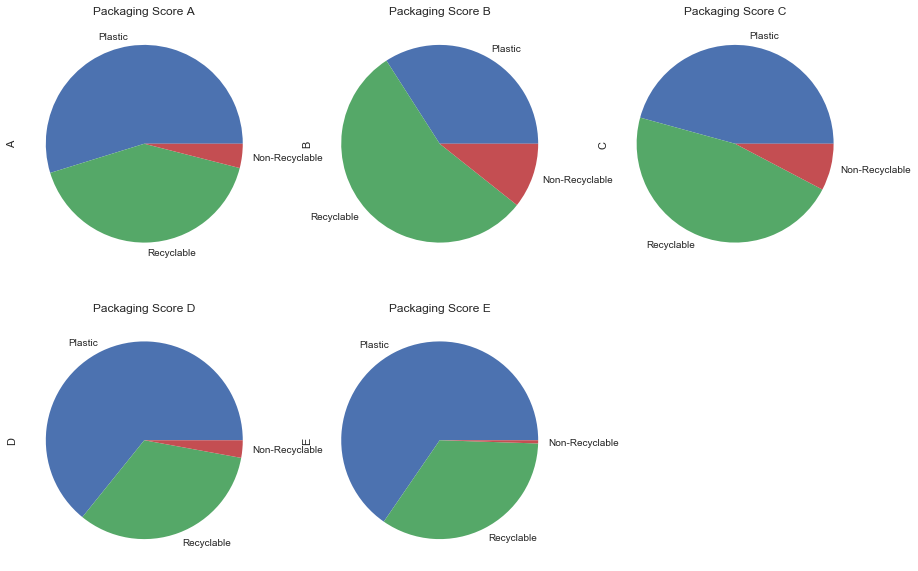

In [58]:
plt.figure(figsize = (15,10))
nutri_pack.loc['A'].plot.pie(ax=plt.subplot(231), title='Packaging Score A')
nutri_pack.loc['B'].plot.pie(ax=plt.subplot(232), title='Packaging Score B')
nutri_pack.loc['C'].plot.pie(ax=plt.subplot(233), title='Packaging Score C')
nutri_pack.loc['D'].plot.pie(ax=plt.subplot(234), title='Packaging Score D')
nutri_pack.loc['E'].plot.pie(ax=plt.subplot(235), title='Packaging Score E')

In [59]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en',
                 'stores', 'countries_en','additives_n',
                 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g',
                 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                 'carbon-footprint_100g', 'first_packaging_code_geo']

**Number of Ing containing Palm_oil**

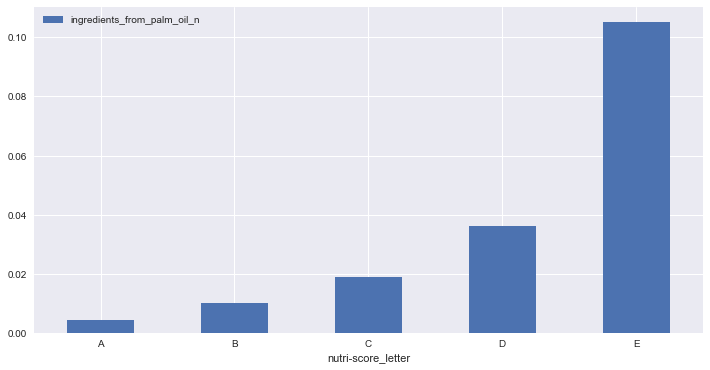

In [60]:
nutri_palm = data[['nutri-score_letter', 'ingredients_from_palm_oil_n']].groupby('nutri-score_letter').mean()
nutri_palm.plot.bar(rot=0, figsize = (12,6))

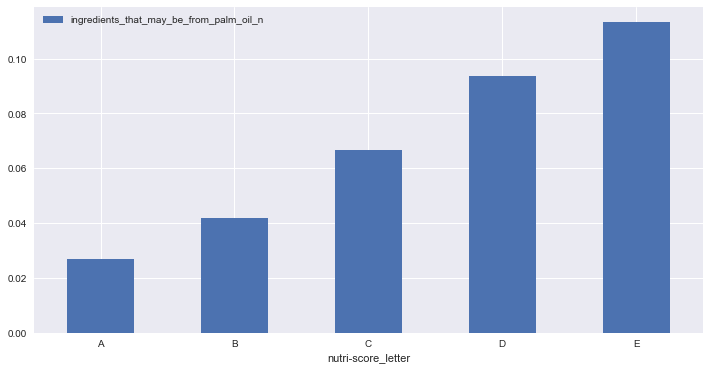

In [61]:
may_nutri_palm = data[['nutri-score_letter', 'ingredients_that_may_be_from_palm_oil_n']].groupby('nutri-score_letter').mean()
may_nutri_palm.plot.bar(rot=0, figsize = (12,6))

In [62]:
def replace(col, contains, replace_by):
    data.loc[data[col].str.contains(contains), col] = replace_by

In [63]:
data['labels_en'].fillna('Unknown', inplace = True)
replace('labels_en','organic','Bio')
replace('labels_en','biologique','Bio')
replace('labels_en','Biologique','Bio')
replace('labels_en','bio','Bio')
replace('labels_en','Organic','Bio')
replace('labels_en','vegan','Vegan')
replace('labels_en','Vegan','Vegan')

In [64]:
replace('labels_en','Green Dot','Green Dot')
replace('labels_en','veget','Vegetarian')
replace('labels_en','Veget','Vegetarian')

In [65]:
data['labels_en'].value_counts()

Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                    595600
Bio                                                                                                                                                                                                                                                                                                                                                                                                                                         38216
Green Dot                                                                                                                           

In [66]:
data[['labels_en', 'nutri-score_letter']].dropna()

,labels_en,nutri-score_letter
0,Unknown,D
2,Unknown,B
3,Unknown,B
5,Unknown,B
6,Unknown,C
9,Unknown,B
10,Unknown,D
11,Unknown,B
12,Unknown,D
13,Unknown,C


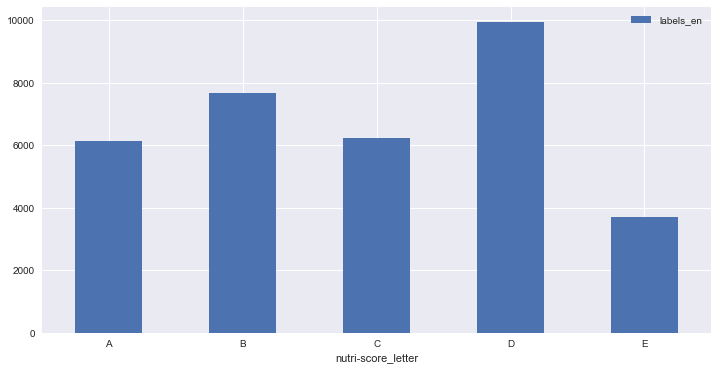

In [77]:
bio_score = data[['labels_en', 'nutri-score_letter']].dropna().query('labels_en == "Bio"').groupby('nutri-score_letter').count()
bio_score.plot.bar(rot=0, figsize = (12,6));

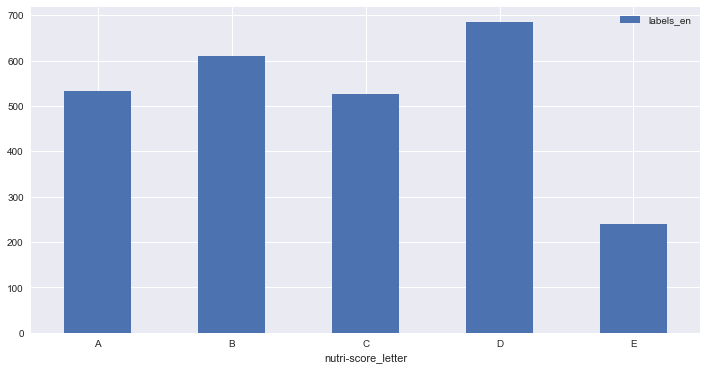

In [78]:
vegan_score = data[['labels_en', 'nutri-score_letter']].dropna().query('labels_en == "Vegan"').groupby('nutri-score_letter').count()
vegan_score.plot.bar(rot=0, figsize = (12,6));

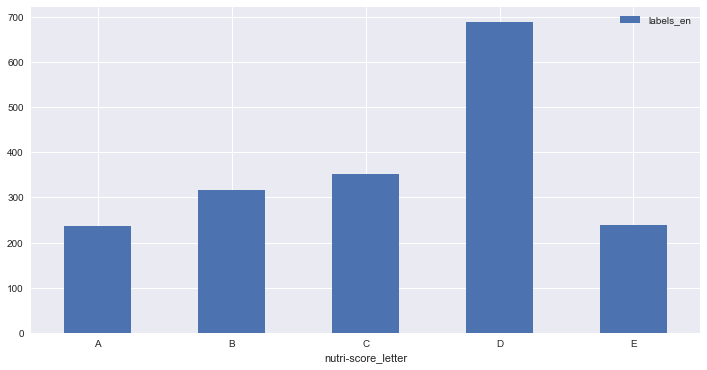

In [79]:
veggie_score = data[['labels_en', 'nutri-score_letter']].dropna().query('labels_en == "Vegetarian"').groupby('nutri-score_letter').count()
veggie_score.plot.bar(rot=0, figsize = (12,6))

In [86]:
veggie_score['labels_en']

316

In [89]:
score_labels = pd.DataFrame({'Veggie':veggie_score['labels_en'], 'Vegan':vegan_score['labels_en'], 'Bio':bio_score['labels_en']})

In [90]:
score_labels

,Veggie,Vegan,Bio
nutri-score_letter,,,
A,237,534,6129
B,316,610,7671
C,352,526,6232
D,688,685,9941
E,239,241,3701


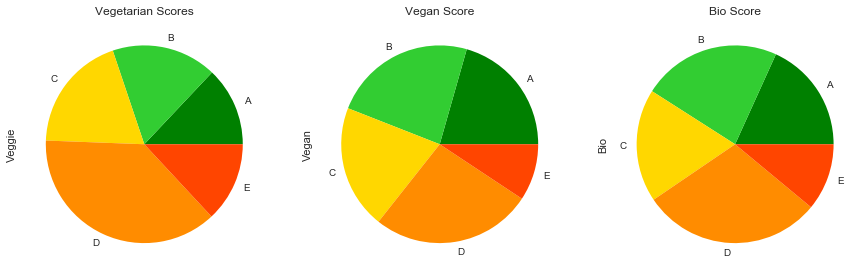

In [102]:
plt.figure(figsize = (15,10))
score_labels['Veggie'].plot.pie(ax=plt.subplot(231), title='Vegetarian Score', colors=nutri_score_colors)
score_labels['Vegan'].plot.pie(ax=plt.subplot(232), title='Vegan Score', colors=nutri_score_colors)
score_labels['Bio'].plot.pie(ax=plt.subplot(233), title='Bio Score', colors=nutri_score_colors)

In [118]:
bio_plastic = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Bio') & (data['packaging_tags'] == 'Plastic')].count()[0]
bio_reclycl = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Bio') & (data['packaging_tags'] == 'Recyclable')].count()[0]
bio_dirt = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Bio') & (data['packaging_tags'] == 'Non-Recyclable')].count()[0]

bio_pack = [bio_plastic, bio_reclycl, bio_dirt]

In [119]:
veggie_plastic = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegetarian') & (data['packaging_tags'] == 'Plastic')].count()[0]
veggie_reclycl = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegetarian') & (data['packaging_tags'] == 'Recyclable')].count()[0]
veggie_dirt = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegetarian') & (data['packaging_tags'] == 'Non-Recyclable')].count()[0]

veggie_pack = [veggie_plastic, veggie_reclycl, veggie_dirt]

In [120]:
vegan_plastic = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegan') & (data['packaging_tags'] == 'Plastic')].count()[0]
vegan_reclycl = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegan') & (data['packaging_tags'] == 'Recyclable')].count()[0]
vegan_dirt = data[['packaging_tags', 'labels_en']][(data['labels_en'] == 'Vegan') & (data['packaging_tags'] == 'Non-Recyclable')].count()[0]

vegan_pack = [vegan_plastic, vegan_reclycl, vegan_dirt]

In [125]:
label_recycl = pd.DataFrame({'Bio':bio_pack, 'Veggie':veggie_pack, 'Vegan': vegan_pack})
label_recycl.index = ['Plastic', 'Recyclable', 'Non-Recyclable']

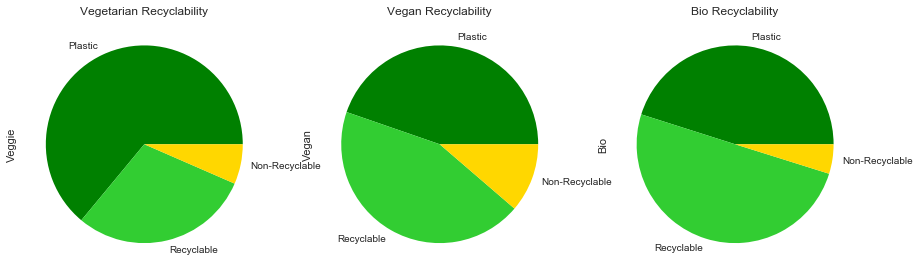

In [126]:
plt.figure(figsize = (15,10))
label_recycl['Veggie'].plot.pie(ax=plt.subplot(231), title='Vegetarian Recyclability', colors=nutri_score_colors)
label_recycl['Vegan'].plot.pie(ax=plt.subplot(232), title='Vegan Recyclability', colors=nutri_score_colors)
label_recycl['Bio'].plot.pie(ax=plt.subplot(233), title='Bio Recyclability', colors=nutri_score_colors)

In [59]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en',
                 'stores', 'countries_en','additives_n',
                 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g',
                 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                 'carbon-footprint_100g', 'first_packaging_code_geo']

**Global Food Packaging:**

In [151]:
categ_plastic = data[['Category', 'packaging_tags']][(data['packaging_tags'] == 'Plastic')].groupby('Category').count()['packaging_tags']

categ_recy = data[['Category', 'packaging_tags']][(data['packaging_tags'] == 'Recyclable')].groupby('Category').count()['packaging_tags']

categ_nonrec = data[['Category', 'packaging_tags']][(data['packaging_tags'] == 'Plastic')].groupby('Category').count()['packaging_tags']

category_pack = pd.DataFrame({'Plastic':categ_plastic, 'Recyclable':categ_recy, 'Non-Recyclable':categ_nonrec})

category_pack.drop(index = 'Unknown', inplace = True)

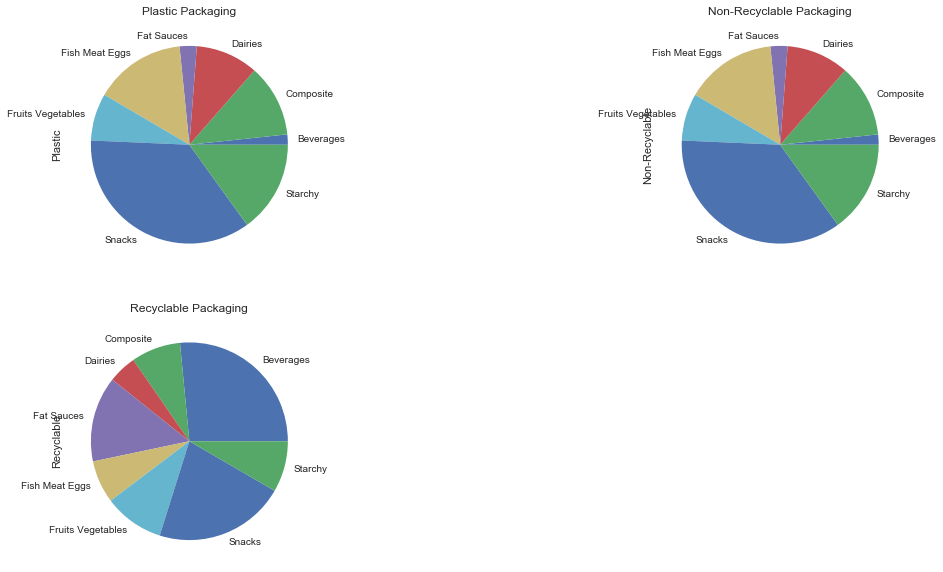

In [152]:
plt.figure(figsize = (15,10))
category_pack['Plastic'].plot.pie(ax=plt.subplot(231), title='Plastic Packaging')
category_pack['Recyclable'].plot.pie(ax=plt.subplot(234), title='Recyclable Packaging')
category_pack['Non-Recyclable'].plot.pie(ax=plt.subplot(233), title='Non-Recyclable Packaging')

In [ ]:
#liste_pack = ['Plastic, Recyclable', 'Non-Recyclable']

#def clean(col, liste, replace_by):
    #for i in range (0,data.shape[0]):
     #   if not data[col][i] in liste:
    #        data[col][i] = replace_by

#clean('packaging_tags', liste_pack, 'Other')